# Εργαστηριακή Άσκηση 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
import scipy.special
from math import log

In [2]:
# Η συνάρτηση grayCode δέχεται έναν αριθμό n και επιστρέφει έναν πίνακα g που περιέχει 
# την κωδικοποίηση Gray για αριθμούς με n bits. 
# Αυτό γίνεται καλώντας αναδρομικά την συνάρτηση gray_code_recurse

def grayCode(n):
    def gray_code_recurse (g,n):
        k=len(g)
        if n<=0:
            return
        else:
            for i in range (k-1,-1,-1):
                char='1'+g[i]
                g.append(char)
            for i in range (k-1,-1,-1):
                g[i]='0'+g[i]

            gray_code_recurse (g,n-1)

    g=['0','1']
    gray_code_recurse(g,n-1)
    return g

In [3]:
# Η συνάρτηση naturalBinaryCoding δέχεται έναν αριθμό n  και επιστρέφει έναν πίνακα
# με δυαδικούς αριθμούς με n bits (ή ισοδύναμα μέχρι τον αριθμό 2**n, ο οποίος προκύπτει
# με αριστερή ολίσθηση του 1 κατά n bits)

def naturalBinaryCoding(n):
    binary_levels = []
    for i in range(1 << n):
        binary_levels.append('{:0{}b}'.format(i, n))
    return binary_levels

In [4]:
# Η συνάρτηση generateRandomBits παράγει n_bits τυχαία δυαδικά ψηφία

def generateRandomBits(n_bits):
    bitstream = []
    for i in range(n_bits):
        random_bit = random.randint(0, 1)
        bitstream.append(random_bit)
    return bitstream

In [5]:
# Η συνάρτηση createLevels χωρίζει το διάστημα [-Α, Α] σε L-1 ίσα διαστήματα,
# έτσι ώστε να περιέχει πάντα τα άκρα του διαστήματος

def createLevels(A, L):
    y = []
    step = (A - (-A)) / (L - 1)
    for i in range(L):
        y.append(-A + i * step)
    return y

In [6]:
# Η συνάρτηση createSymbols δέχεται ως όρισμα έναν πίνακα με bits και
# ομαδοποιεί τα γειτονικά ψηφία σε σύμβολα με μήκος k

def createSymbols(k, bitstream):
    n_bits = len(bitstream)
    symbols = []
    for i in range(0, n_bits - k + 1, k):
        symbol = ""
        for j in range(k):
            symbol += str(bitstream[i+j])
        symbols.append(symbol)
    return symbols

In [7]:
# Η συνάρτηση rootRaisedCosine δημιουργεί έναν παλμό τετραγωνικής ρίζας ανυψωμένου συνημιτόνου 
# με συντελέστή εξάπλωσης roll_off και τάξη που καθορίζεται από τον ρυθμό δειγματόληψίας (nsample) 
# και την καθύστερηση που θα εισάγει (delay)

def rootRaisedCosine(nsamp, roll_off, delay):
    F0 = 0.5 / nsamp
    Fd = 1
    Fs = Fd * nsamp
    Td = 1 / Fd
    Ts = 1 / Fs
    F1 = F0 * (1 - roll_off)
    F2 = F0 * (1 + roll_off)
    filter_order = 2 * nsamp * delay

    t = np.arange(0, filter_order, Td)
    h = []
    for i in range(len(t)):
        t_shifted = t[i] - filter_order / 2
        if t_shifted == 0:
            h.append(np.sqrt(2 * F0) *(1 + roll_off * ((4 / np.pi) - 1)))
        elif t_shifted == 1 / 8 / roll_off / F0 or t_shifted == - 1 / 8 / roll_off / F0 :
            h.append((roll_off * np.sqrt(F0)) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / roll_off) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / roll_off)))
        else:
            factor1 = np.sqrt(2 * F0) / (1 - 64 * roll_off* roll_off * F0 * F0 * t_shifted * t_shifted)
            factor2 = np.sin(2 * np.pi * F1 * t_shifted) / (2 * np.pi * F0 * t_shifted)
            factor3 = (4 * roll_off / np.pi) * np.cos(2 * np.pi * F2 * t_shifted) 
            h.append(factor1 * (factor2 + factor3))


    plt.plot(t,h)
    plt.grid()
    plt.title('Root raised cosine filter of order %d and roll-off factor %.1f' % (filter_order, roll_off))
    plt.show()
    
    return h

In [8]:
# Η συνάρτηση upSample αυξάνει τον αριθμό των δειγμάτων ενός σήματος signal προσθέτοντας nsamp-1
# μηδενικά μετά από κάθε δείγμα του σήματος

def upSample(signal, nsamp):
    upSampled = []
    for i in range(len(signal) * nsamp):
        if i % nsamp == 0:
            upSampled.append(signal[i // nsamp])
        else:
            upSampled.append(0)
    return upSampled

In [9]:
# Η συνάρτηση downSample μειώνει την συχνότητα δειγματοληψία ενός σήματος signal κατά έναν παράγοντα nsamp 
# κρατώντας μόνο τα δείγματα που είναι πολλάπλάσια του nsamp (0, nsamp, 2*nsamp, ...)

def downSample(signal, nsamp):
    downSampled = []
    for i in range(0, len(signal), nsamp):
        downSampled.append(signal[i])
        
    return downSampled

In [10]:
# Προσθέτει λευκό γκαουσσιανό θόρυβο με μέση τιμή μ (mu) και διασπορά σ^2 (sigma)

def generateAWGN(signal, mu, sigma):
    noise = sigma * np.random.randn(len(signal)) + mu
    return noise

In [11]:
n_bits = 80000
bitstream = generateRandomBits(n_bits) # Δημιουργία τυχαίων bits

L = 16 # Αριθμός επιπέδων της ASK
A = L-1 
k = int(log(L,2)) # Αριθμός ψηφίων σε κάθε σύμβολο
n_symb = n_bits / k # Αριθμός συμβόλων που προκύπτουν από τα τυχαία bits

y_levels = createLevels(A, L) # [-15, -13, -11 ... 11 13 15]

symbols = createSymbols(k, bitstream) # Ομαδοποίηση σε σύμβολα

gray_encoding = grayCode(k) # Εφαρμογή κωδικοποίησης Gray

# Η x_gray περιέχει το επίπεδο τάσης στο οποίο αντιστοιχεί καθένα από τα σύμβολα
x_gray = [] 
for i in range(len(symbols)):
    x_gray.append(y_levels[gray_encoding.index(symbols[i])])

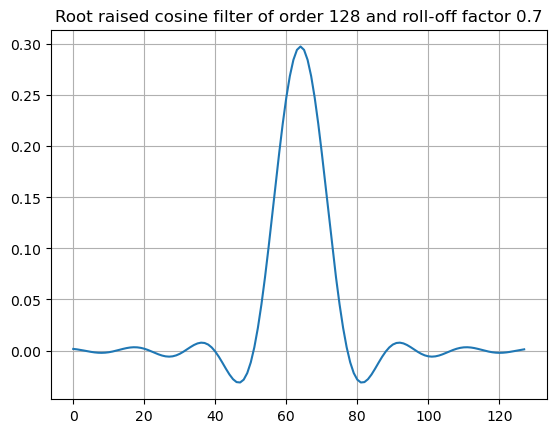

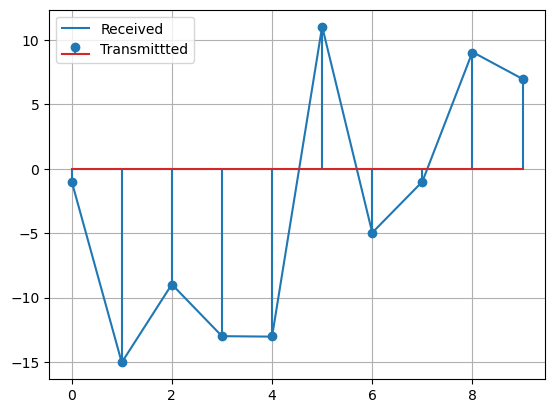

In [12]:
nsamp = 16
roll_off = 0.7
delay = 4
filter_order = 2 * nsamp * delay

# Δημιουργία του φίλτρου ανυψωμένου συνημιτόνου
# Υπερδειγμάτιση και συνέλιξη με τους τυχαίους ακεραίους 
filt = rootRaisedCosine(nsamp, roll_off, delay)
y = upSample(x_gray, nsamp)
y_transmitted = scipy.signal.convolve(y, filt)

# Στον δέκτη το σήμα φιλτράρεται πάλι από το φίλτρο root raised cosine
y_received = scipy.signal.convolve(y_transmitted, filt)
y_final = downSample(y_received, nsamp)

# Αποκόπτουμε τις ουρές που προέκυψαν από τις συνελίξεις
y_final = y_final[2 * delay: len(y_final) - 2 *delay]

# Εμφανίζουμε σε κοινό διάγραμμα το ληφθέν σήμα μετά την υποδειγμάτιση 
# και τους αρχικούς τυχαίους ακεραίους
t = np.arange(0, len(y[:10]))
plt.figure()
plt.plot(t, y_final[:10])
plt.stem(t, x_gray[:10])
plt.legend(['Received','Transmittted'])
plt.grid()
plt.show()

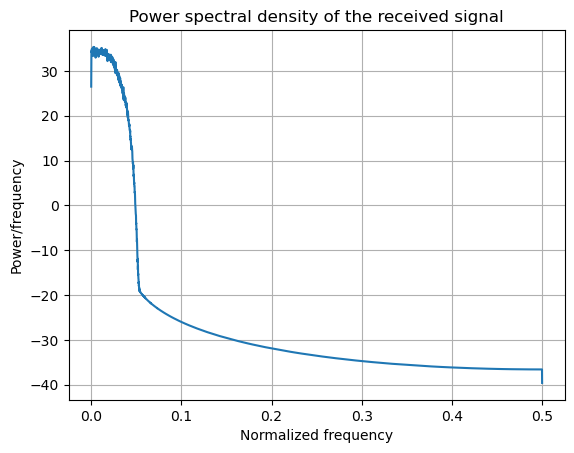

In [13]:
# Υπολογίζουμε την φασματική πυκνότητα ισχύος του ληφθέντος σήματος

f, Pxx_den = scipy.signal.welch(y_received, window='hamming', nperseg=8192)
Pxx_den = 10 * np.log10(Pxx_den)
fig = plt.figure()
plt.plot(f, Pxx_den)
plt.grid()
plt.title('Power spectral density of the received signal')
plt.xlabel('Normalized frequency')
plt.ylabel('Power/frequency')
plt.show()

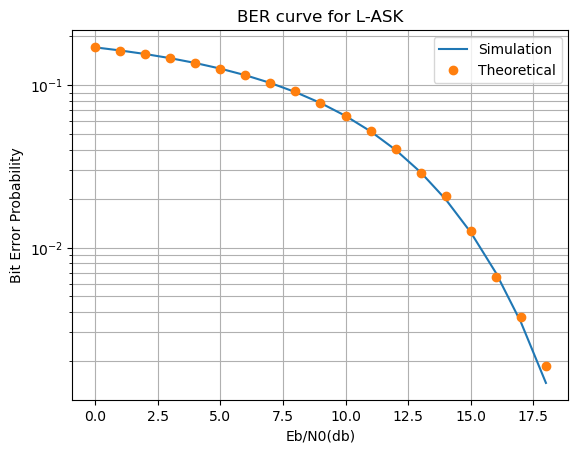

In [14]:
# Υπολογισμός της πιθανότητας εσφαλμένου ψηφίου θεωρητικά και μέσω προσομοίωσης

berTheoretical = []
berSimulation = []
EbN0_max = 20

for EbN0_db in range(1,EbN0_max):
    
    # SNR και Eb/N0 σε γραμμική κλίμακα και dB
    EbN0 = 10 ** (EbN0_db * 0.1)
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)

    # Υπολογισμός της ισχύος του μεταδιδομένου σήματος και της ισχύος θορύβου 
    # ώστε να έχουμε το επιθυμητό SNR
    P = sum(y_transmitted * y_transmitted) / len(y_transmitted)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)

    # Προσθήκη θορύβου AWG
    mu = 0
    sigma = np.sqrt(Pn)
    noise = generateAWGN(y_transmitted, mu, sigma)
    y_noisy = y_transmitted + noise

    # Στον δέκτη γίνεται φιλτράρισμα και υποδειγμάτιση
    z_received = scipy.signal.convolve(y_noisy, filt)
    z_final = downSample(z_received, nsamp)
    
    # Περικοπή των ουρών λόγω των συνελίξεων
    z_final = z_final[2 * delay : len(z_final) - 2 * delay]

    # Απόφαση για το επίπεδο στο οποίο αντιστοιχεί το σύμβολο που ελήφθη
    for i in range(len(z_final)):
        # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        differences = np.abs(y_levels - z_final[i]) 
        m = min(differences) # Εύρεση ελάχιστης απόστασης
        [index], = np.where(differences == m)
        z_final[i] = y_levels[index]
    
    # Λόγω της κωδικοποίησης Gray θεωρούμε ότι σε κάθε λάθος έχουμε ένα εσφαλμένο bit
    error = 0
    for i in range(len(z_final)):
        if x_gray[i] != z_final[i]:
            error += 1
    
    # Πιθανότητα λάθους = αριθμός λαθών / αριθμών ψηφίων
    berSimulation.append(error/n_bits)
    # Θεωρητική τιμή της πιθανότητας εσφαλμένου ψηφίου
    Pe = (L - 1) / L * scipy.special.erfc(np.sqrt(3 * k / (L * L - 1) * EbN0))
    berTheoretical.append(Pe / k)

plt.figure()
plt.semilogy(berTheoretical)
plt.semilogy(berSimulation,'o')
plt.legend(['Simulation', 'Theoretical'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for L-ASK')
plt.grid(which='both')
plt.show()

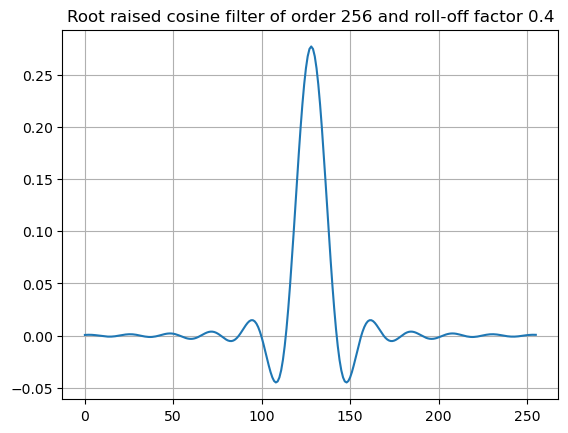

In [15]:
# Επαναλάμβάνουμε την παραπάνω διαδικασία, αλλά θεωρούμε κωδικοποίηση με δυαδικούς αριθμούς αντί για Gray

n_bits = 80000
bitstream = generateRandomBits(n_bits)

L = 16 # Αριθμός επιπέδων της ASK
A = L-1 
k = int(log(L,2)) # Αριθμός ψηφίων σε κάθε σύμβολο
n_symb = n_bits / k # Αριθμός συμβόλων που προκύπτουν από τα τυχαία bits

y_levels = createLevels(A, L) # [-15, -13, -11 ... 11 13 15]
symbols = createSymbols(k, bitstream) # Ομαδοποίηση σε σύμβολα
natural_encoding = naturalBinaryCoding(k) # Κωδικοποίηση με δυαδικούς αριθμούς

# Η x_natural περιέχει το επίπεδο τάσης στο οποίο αντιστοιχεί καθένα από τα σύμβολα
x_natural = []
for i in range(len(symbols)):
    x_natural.append(y_levels[natural_encoding.index(symbols[i])])
    
nsamp = 16
roll_off = 0.4
delay = 8
filter_order = 2 * nsamp * delay

# Δημιουργία του φίλτρου ανυψωμένου συνημιτόνου
# Υπερδειγμάτιση και συνέλιξη με τους τυχαίους ακεραίους 
filt = rootRaisedCosine(nsamp, roll_off, delay)
y = upSample(x_natural, nsamp)
y_transmitted = scipy.signal.convolve(y, filt)

# Στον δέκτη το σήμα φιλτράρεται πάλι από το φίλτρο root raised cosine
y_received = scipy.signal.convolve(y_transmitted, filt)
y_final = downSample(y_received, nsamp)
y_final = y_final[2 * delay: len(y_final) - 2 *delay]

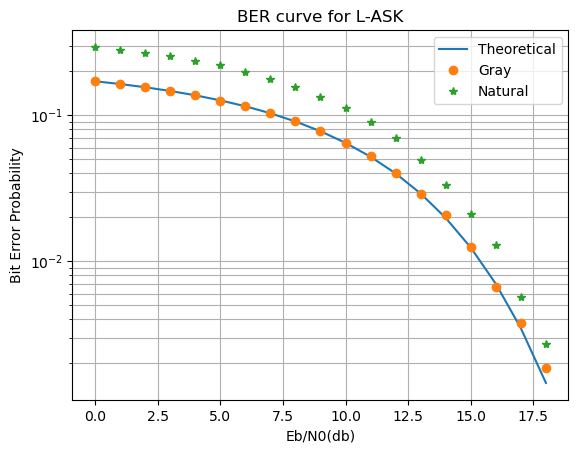

In [16]:
# Υπολογισμός της πιθανότητας εσφαλμένου ψηφίου θεωρητικά και μέσω προσομοίωσης
berSimulation_natural = []
EbN0_max = 20

for EbN0_db in range(1,EbN0_max):
    
    EbN0 = 10 ** (EbN0_db * 0.1)
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)

    # Υπολογισμός της ισχύος του μεταδιδομένου σήματος και της ισχύος θορύβου ώστε να έχουμε το επιθυμητό SNR
    P = sum(y_transmitted * y_transmitted) / len(y_transmitted)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)

    mu = 0
    sigma = np.sqrt(Pn)
    noise = generateAWGN(y_transmitted, mu, sigma)
    y_noisy = y_transmitted + noise

    # Στον δέκτη γίνεται φιλτράρισμα και υποδειγμάτιση
    z_received = scipy.signal.convolve(y_noisy, filt)
    z_final = downSample(z_received, nsamp)
    z_final = z_final[2 * delay : len(z_final) - 2 * delay]

    # Απόφαση για το επίπεδο στο οποίο αντιστοιχεί το σύμβολο που ελήφθη
    for i in range(len(z_final)):
        differences = np.abs(y_levels - z_final[i])
        m = min(differences)
        [index], = np.where(differences == m)
        z_final[i] = y_levels[index]
    
    # Ο final_symbols περιέχει τα bits που αποφασίστηκε ότι ελήφθησαν
    final_symbols = []
    for i in range(len(z_final)):
        # Αντιστοίχηση κάθε επιπέδου που αποφασίστηκε παραπάνω στην δυαδική κωδικοποίηση του
        index = y_levels.index(z_final[i])
        final_symbols.append(natural_encoding[index])

    # Για κάθε εσφαλμένο σύμβολο πρέπει να ελέγξουμε πόσα ψηφία ήταν λάθος, καθώς η κωδικοποίηση 
    # των γειτονικών επιπέδων δεν απέχει πλέον κατά μόνο ένα ψηφίο 
    error = 0
    for i in range(len(z_final)):
        # Εάν ένα σύμβολο είναι λάθος, έλεγξε πόσα ψηφία ελήφθηφαν εσφαλμένα
        if x_natural[i] != z_final[i]:
            for j in range(len(symbols[i])):
                if symbols[i][j] != final_symbols[i][j]:
                    error += 1
        
    berSimulation_natural.append(error/n_bits)

plt.figure()
plt.semilogy(berTheoretical)
plt.semilogy(berSimulation,'o')
plt.semilogy(berSimulation_natural,'*')
plt.legend(['Theoretical', 'Gray', 'Natural'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for L-ASK')
plt.grid(which='both')
plt.show()